# 6.python实现维纳滤波，要求：比较信噪比已知，信噪比未知，图像和噪声自相关函数已知，这三种情况下的图像复原结果。

In [155]:
from scipy.signal import wiener
from numpy import fft
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

In [156]:
# 仿真运动模糊
def motion(sz, motion_angle):
    PSF = np.zeros(sz)
    center_position = (sz[0] - 1) / 2  #找到全0矩阵的中心行数center_position
    motion_tan = math.tan(motion_angle * math.pi / 180)
    motion_cot = 1 / motion_tan
    if motion_tan <= 1: #α≤45°时，PSF[int(center_position+offset),int(center_position-offset)]=1
        for i in range(15):
            offset = round(i * motion_tan)  # 运动的偏移量offset:((center_position-i)*motion_tan) 
            PSF[int(center_position + offset), int(center_position - offset)] = 1
        return PSF / PSF.sum()  # 对点扩散函数进行归一化亮度
    else:#α≥45°时，PSF[int(center_position-offset),int(center_position+offset)]=1
        for i in range(15):
            offset = round(i * motion_cot)
            PSF[int(center_position - offset), int(center_position + offset)] = 1
        return PSF / PSF.sum()


# 对图片进行运动模糊
def make_blurred(input, PSF, eps):
    input_fft = fft.fft2(input)  # 进行二维数组的傅里叶变换
    PSF_fft = fft.fft2(PSF) + eps
    blurred = fft.ifft2(input_fft * PSF_fft)
    blurred = np.abs(fft.fftshift(blurred))
    return blurred

In [157]:
def wiener(input,PSF,K):  # 维纳滤波
    input_fft = np.fft.fft2(input)
    PSF_fft = np.fft.fft2(PSF)
    PSF_fft_1 = np.conj(PSF_fft) / ((np.abs(PSF_fft))**2 + K)*input_fft          
    result = np.fft.ifft2(PSF_fft_1)
    result = np.abs(fft.fftshift(result))
    return result

In [158]:
lena=cv2.imread('C:/Users/user/Desktop/lena.jpg',0)
r,c=lena.shape
#运动模糊
h=motion((r,c),20)
lena_sport=np.abs(make_blurred(lena, h, 1e-3))
#均值为0，方差为1的高斯噪声
lena_gauss=np.random.normal(0,20**0.5,(r,c))
#退化图
lena_PSF=lena_sport+lena_gauss

In [159]:
#原始图片的自相关函数
lena_fft=np.abs(fft.fft2(lena))
#噪声图片的自相关函数
gauss_fft=np.abs(fft.fft2(lena_gauss))

In [160]:
#信噪比SNR已知
k1=sum(sum(gauss_fft))/sum(sum(lena_fft))
lena1=wiener(lena_PSF,h,k1)
#信噪比SNR未知
k2=0.01
lena2=wiener(lena_PSF,h,k2)
#图像和噪声的自相关函数已知
k3=gauss_fft**2/lena_fft**2
lena3=wiener(lena_PSF,h,k3)

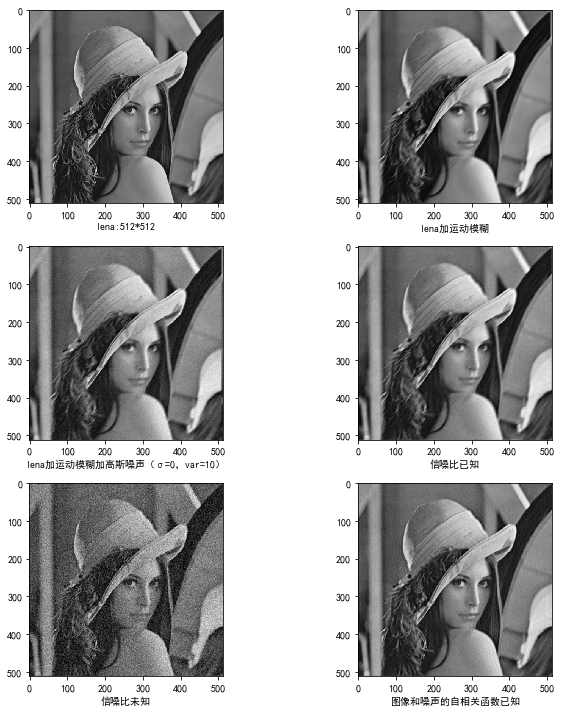

In [161]:
plt.figure(figsize=(10, 10))
plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
plt.subplot(321), plt.imshow(lena, 'gray'),plt.xlabel('lena:512*512')
plt.subplot(322), plt.imshow(lena_sport, 'gray'),plt.xlabel('lena加运动模糊')
plt.subplot(323), plt.imshow(lena_PSF, 'gray'),plt.xlabel('lena加运动模糊加高斯噪声（σ=0，var=10）')
plt.subplot(324), plt.imshow(lena1, 'gray'),plt.xlabel('信噪比已知')
plt.subplot(325), plt.imshow(lena2, 'gray'),plt.xlabel('信噪比未知')
plt.subplot(326), plt.imshow(lena3, 'gray'),plt.xlabel('图像和噪声的自相关函数已知')
plt.tight_layout()
plt.show()